In [53]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

In [54]:
df_singapore = pd.read_csv('./datasets/singapore.csv')
df_asksingapore = pd.read_csv('./datasets/asksingapore.csv')

# Combine r\singapore and r\asksingapore posts in 50:50 proportions
df = pd.concat([df_singapore[:9990], df_asksingapore[:9990]]).reset_index(drop=True)

# Replace '[removed]' with whitespaces
df['selftext'].replace({'[removed]': ''}, inplace=True)

# Replace np.nan with str(nan) before concatenating title+selftext  (nan to be removed later)
df.fillna('nan', inplace=True)

# Concat selftext + title into new column
df['all_text'] = df['title']+' '+df['selftext']   # str(selftext) as 1398 rows are NaN which will result in the corresponding loss of the 'title' data
df['all_text'][0]

"Singapore leaders congratulate Xi Jinping on his reappointment as China's president nan"

In [55]:
# Create function to automate word-cleaning

def clean_text(text):
    # Remove HTML elements e.g. tags
    review_text = BeautifulSoup(text).get_text()    
    
    # Remove non-alpha characters and nan
    letters_only = re.sub('[^a-zA-Z]|nan', " ", review_text)
    
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # set(stopwords) to make faster search
    stops = set(stopwords.words('english'))
    
    # Remove stopwords
    meaningful_words = [w for w in words if not w in stops]

    # Stem words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in meaningful_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in stemmed_words]   # doesnt add value in this case as words are more colloquial
    
    # Join back the words into one string separated by space
    return(" ".join(lemmatized_words))     # str_separator.join(iterable_string)

In [56]:
# Convert subreddit into binary variables where r\askSingapore=1, r\Singapore=0

df['subreddit'] = df['subreddit'].map(lambda x: 1 if x=='askSingapore' else 0)
df['subreddit']

0        0
1        0
2        0
3        0
4        0
        ..
19956    1
19957    1
19958    1
19959    1
19960    1
Name: subreddit, Length: 19961, dtype: int64

In [57]:
# # Characters and word count of each selfteext
df['char_count'] = df['all_text'].map(len)
df['word_count'] = df['all_text'].map(lambda x: len(x.split()))
df.describe()

,subreddit,char_count,word_count
count,19961.000000,19961.000000,19961.000000
mean,0.499775,289.603326,50.455588
std,0.500012,595.314796,94.088135
min,0.000000,2.000000,1.000000
25%,0.000000,55.000000,9.000000
50%,0.000000,108.000000,19.000000
75%,1.000000,317.000000,57.000000
max,1.000000,16237.000000,2645.000000


## Visualizing Character Count and Word Count of Titles

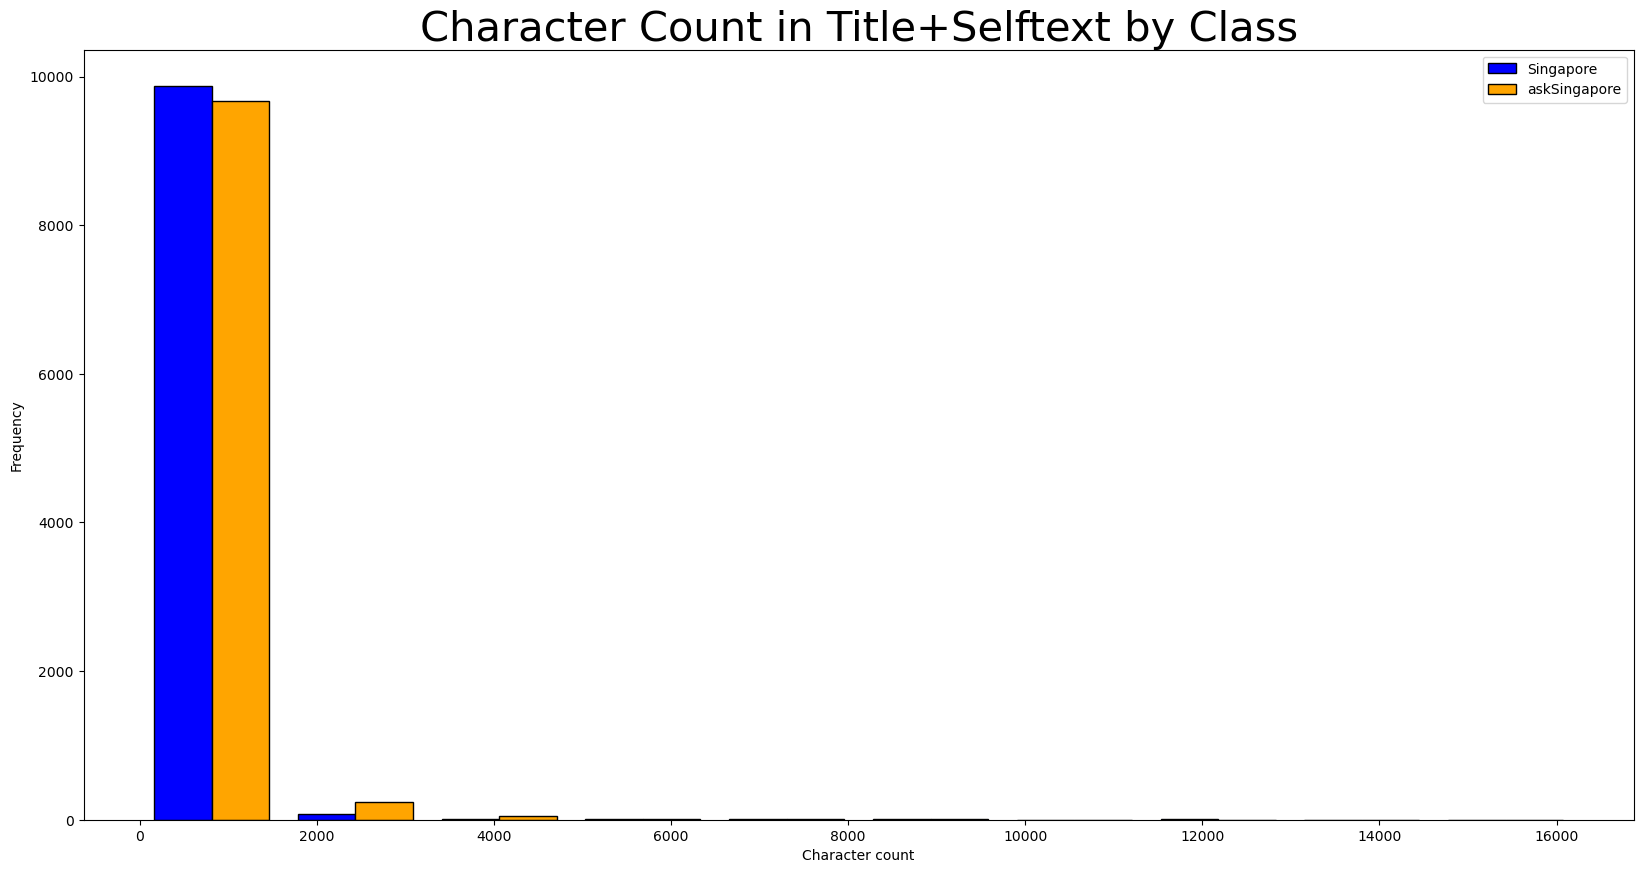

In [66]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['char_count'], 
          df[df['subreddit']==1]['char_count']],
         bins=10, color=['blue', 'orange'], ec='k')
plt.title('Character Count in Title+Selftext by Class', fontsize=30)
plt.legend(['Singapore', 'askSingapore'])
plt.xlabel('Character count')
plt.ylabel('Frequency');

# r\askSingapore tends to have a much bigger character count than r\Singapore. 
# This is likely because r\askSingapore have more question-format posts or because more people are venting frustration there?
# r\Singapore have a more balanced distribution with the average char_count around 1,500 char.

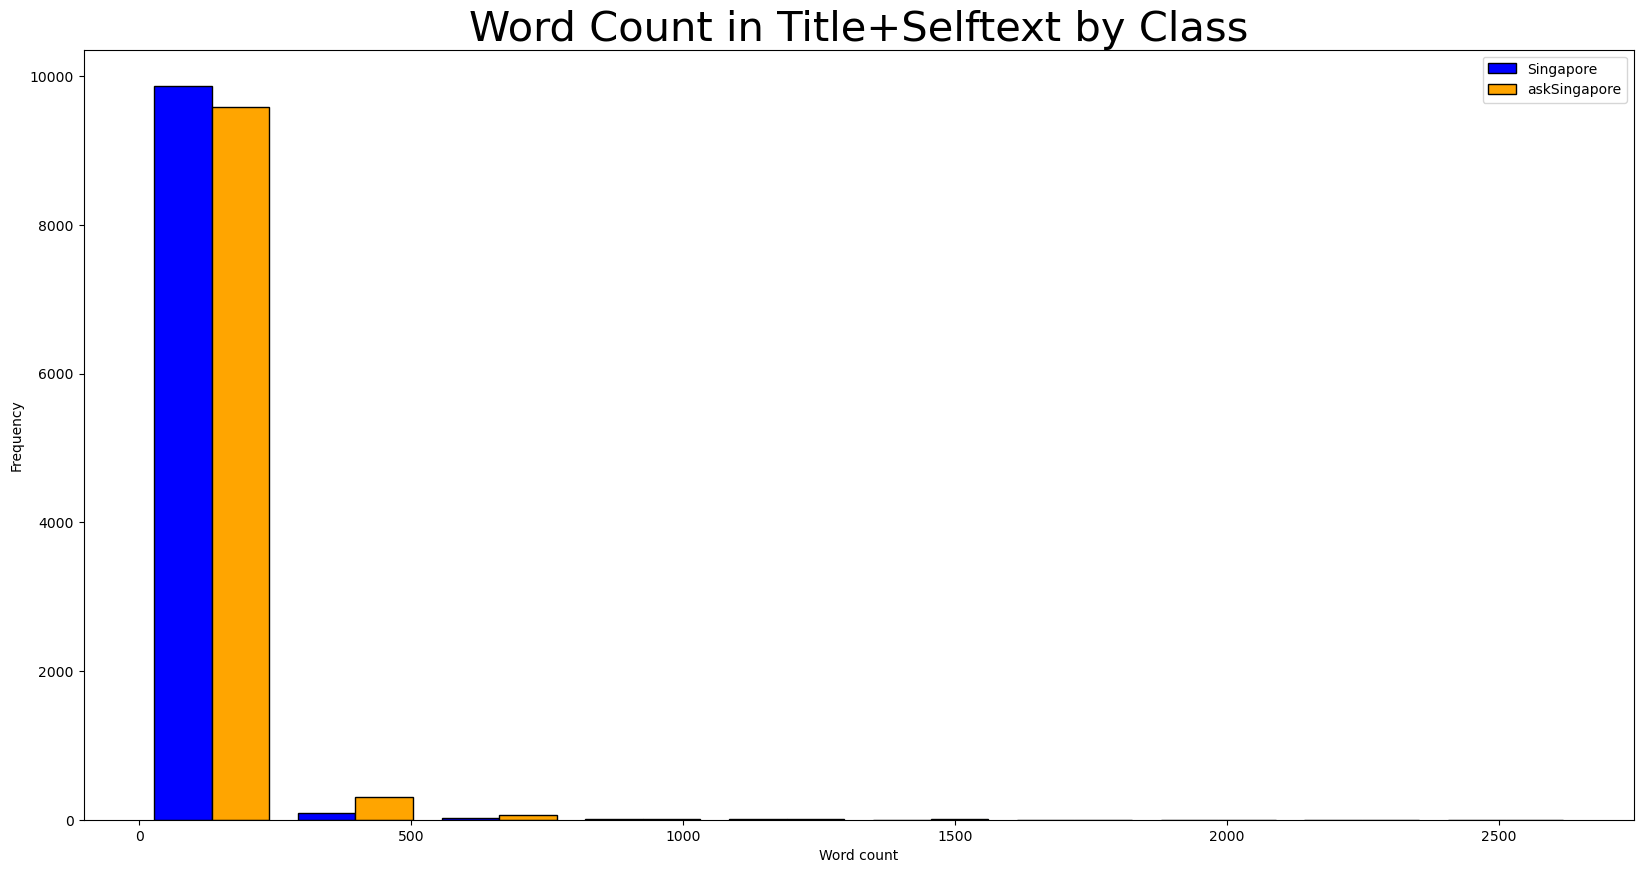

In [67]:
plt.figure(figsize=(20,10))
plt.hist([df[df['subreddit']==0]['word_count'], 
          df[df['subreddit']==1]['word_count']],
         bins=10, color=['blue', 'orange'], ec='k')
plt.title('Word Count in Title+Selftext by Class', fontsize=30)
plt.legend(['Singapore', 'askSingapore'])
plt.xlabel('Word count')
plt.ylabel('Frequency');

In [68]:
# Clean, stem, and lemmatize Titles

df['all_text'] = df['all_text'].map(lambda x: clean_text(x))
df['all_text']

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


0        singapor leader congratul xi jinp reappoint ch...
1        woman caught traffic polic drive errat licenc ...
2        anyon tell anyth hous photo taken singapor hou...
3        incred miniatur kuala lumpur landmark tini museum
4         singapor sea cut job e commerc unit shope report
                               ...                        
19956    work abroad fresh graduat u hey graduat univer...
19957    agreement place muslim commun prevent youth en...
19958    anyon use torrent illeg look download music us...
19959    legal insult someon public behav unreason exam...
19960    place good internet asid starbuck wireless sg ...
Name: all_text, Length: 19961, dtype: object

In [69]:
# Initialize a count vectorizer and fitting it

cvec = CountVectorizer(analyzer='word', min_df=3)
terms = cvec.fit_transform(df['all_text'])
text = pd.DataFrame(terms.todense(), columns=cvec.get_feature_names_out())
text.head()

,aa,aaa,ab,aback,abalon,abandon,abc,abdomen,abduct,abe,...,zip,zksync,zn,zombi,zone,zoo,zoologist,zoom,zouk,zoukout
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Insert target subreddit back into the vectorized text df

target_r = df['subreddit']   
text.insert(0, 'target_r', target_r)
text.head()

,target_r,aa,aaa,ab,aback,abalon,abandon,abc,abdomen,abduct,...,zip,zksync,zn,zombi,zone,zoo,zoologist,zoom,zouk,zoukout
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Looking at the most common words

In [71]:
# Create a dict for the most common words to the counts
term_counts = {col: text[col].sum() for col in text.columns[1:]}

# Create a dataframe for the Term Count Distribution ("tcd")
tcd = pd.DataFrame(term_counts, index=['counts'])
tcd = tcd.T
tcd.head()

,counts
aa,22
aaa,4
ab,16
aback,9
abalon,6


In [72]:
# Sort tcd by count values
tcd.sort_values(ascending=False, by='counts').head(10)

,counts
singapor,6555
like,4192
get,4098
sg,3664
work,3282
aircon,3268
would,3197
time,2973
know,2945
go,2823


In [73]:
# Take the top 20 words and visualize them into a heatmap
top20 = list(tcd.sort_values(by='counts', ascending=False).head(20).index)
top20.append('target_r')
top20

['singapor',
 'like',
 'get',
 'sg',
 'work',
 'aircon',
 'would',
 'time',
 'know',
 'go',
 'http',
 'year',
 'anyon',
 'want',
 'one',
 'com',
 'look',
 'peopl',
 'day',
 'servic',
 'target_r']

C:\Users\leagu\AppData\Local\Temp\ipykernel_6548\1432813246.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


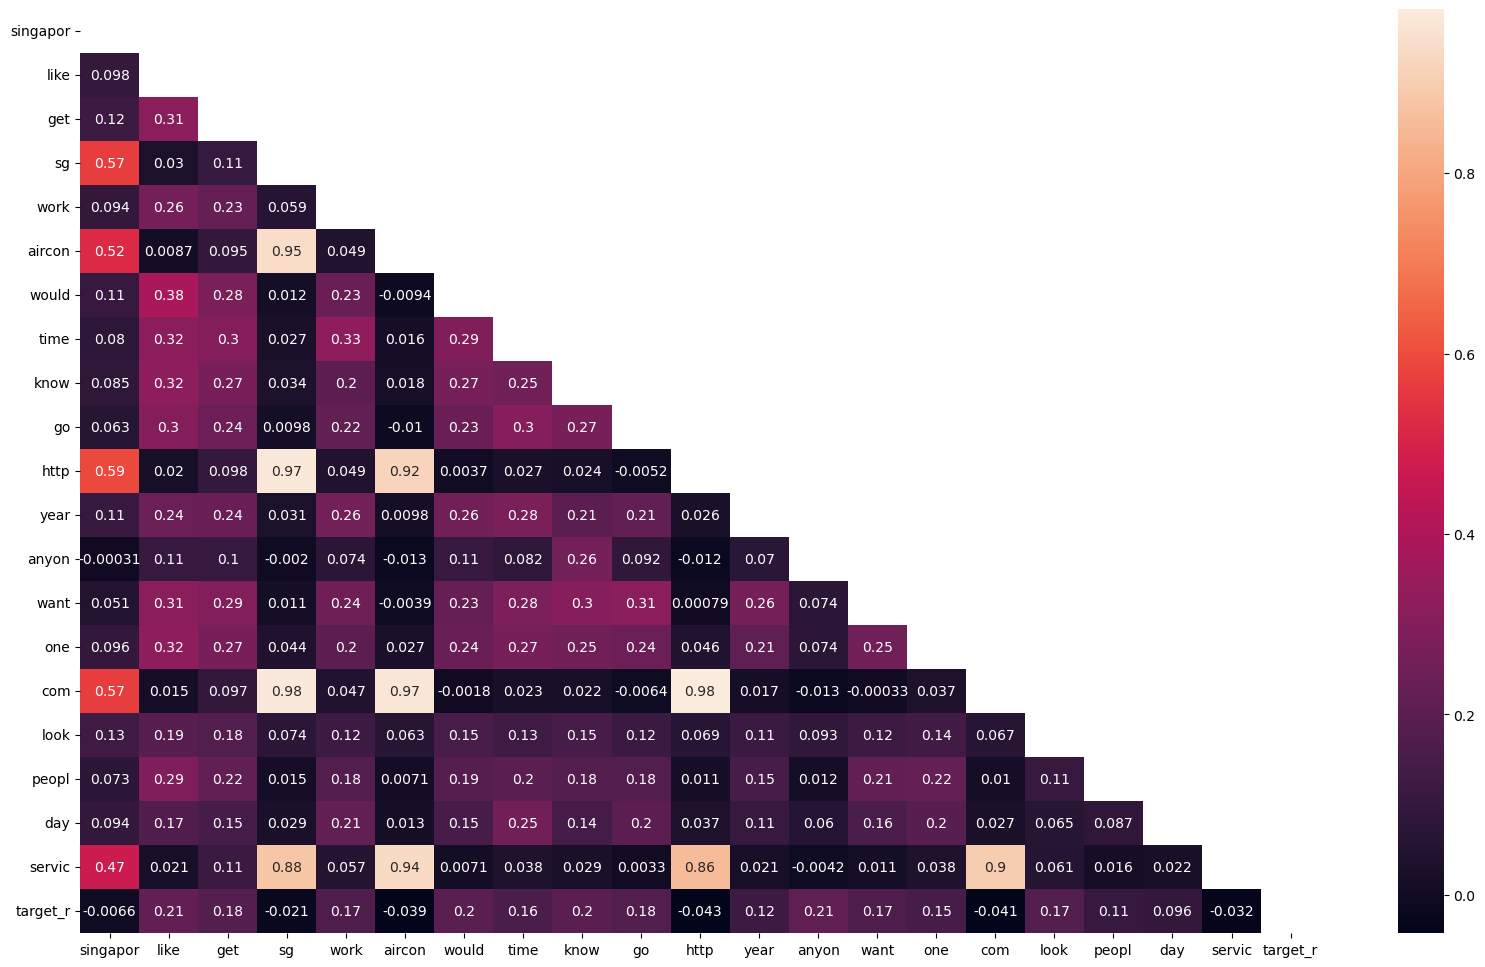

In [74]:
# Creating the correlation heatmap
plt.figure(figsize=(20,12))
corr = text[top20].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask = mask, annot=True);

# No strong correlation between the 'target_r' and top20 most common words. 
# Strongest correlation is the negative corr of 'like' and 'anyon' with 'target' at +0.21  which suggests that given a higher count of these two words, the more likely it will be 1.
# In other words, the word 'like' and 'anyon' occur relatively more frequently in r\askSingapore than in r\Singapore

In [75]:
# Getting the term frequency relative to target
text.groupby('target_r').mean().T.sort_values(by=0, ascending=False)

target_r,0,1
singapor,0.335003,0.321772
aircon,0.322384,0.004912
http,0.234452,0.037891
sg,0.230846,0.136227
com,0.205709,0.025862
...,...,...
lowkey,0.000000,0.000702
bend,0.000000,0.000501
lozeng,0.000000,0.000401
strand,0.000000,0.000501


In [76]:
text.groupby('target_r').sum().T.sort_values(by=0, ascending=False).head(35)

# At face value, groupby mean or sum yields the same results

target_r,0,1
singapor,3345,3210
aircon,3219,49
http,2341,378
sg,2305,1359
com,2054,258
coolcar,1780,0
servic,1522,444
instal,1103,59
get,881,3217
year,699,2011


## Conduct Hypothesis Testing to find overlap of common words that have the same mean frequency)

In [77]:
# Getting the top 1000 words for both classes

top_n = 1000
top_words_singapore = list(text.groupby('target_r').mean().T.sort_values(0, ascending=False).head(top_n).index)
top_words_asksingapore = list(text.groupby('target_r').mean().T.sort_values(1, ascending=False).head(top_n).index)

# List of words that are in the top 1000 for both classes
top_words_overlap = [w for w in top_words_singapore if w in top_words_asksingapore]

print(f'Number of overlapped words: {len(top_words_overlap)}')   # there are 754 overlapped words
top_words_overlap


Number of overlapped words: 754


['singapor',
 'http',
 'sg',
 'com',
 'servic',
 'get',
 'year',
 'like',
 'peopl',
 'time',
 'day',
 'help',
 'anyon',
 'work',
 'know',
 'new',
 'go',
 'one',
 'would',
 'use',
 'look',
 'need',
 'question',
 'singaporean',
 'want',
 'still',
 'first',
 'free',
 'plea',
 'best',
 'live',
 'say',
 'take',
 'hdb',
 'price',
 'think',
 'find',
 'good',
 'www',
 'make',
 'compani',
 'job',
 'also',
 'place',
 'tri',
 'even',
 'ask',
 'top',
 'food',
 'month',
 'care',
 'anyth',
 'friend',
 'talk',
 'home',
 'thing',
 'realli',
 'got',
 'see',
 'back',
 'buy',
 'issu',
 'old',
 'appli',
 'small',
 'man',
 'gener',
 'air',
 'thank',
 'bto',
 'come',
 'pay',
 'guy',
 'discus',
 'offer',
 'world',
 'call',
 'much',
 'rule',
 'could',
 'money',
 'countri',
 'ce',
 'hous',
 'reason',
 'public',
 'polit',
 'way',
 'school',
 'feel',
 'famili',
 'goe',
 'card',
 'clean',
 'post',
 'random',
 'move',
 'may',
 'account',
 'woman',
 'recommend',
 'delet',
 'experi',
 'provid',
 'mani',
 'plan',
 's

_Conduct hypothesis testing on the top_words_overlap to see if those words have the same mean frequency in both classes. Overlapped words with the same mean frequency will likely add noise than signal in our model. We will set our alpha to 0.01._  

H<sub>0</sub>: The _r\Singapore_ and _r\askSingapore_ have the same mean frequency for word _x_.  
H<sub>1</sub>: The _r\Singapore_ and _r\askSingapore_ do not have the same mean frequency for word _x_.


In [78]:
# Import the scipy.stats library to access the t-test function
from scipy.stats import ttest_ind

# Storing p-value, t-stat, and word into a dict
ttest_dict={}

for word in top_words_overlap:
    ttest_dict[word] = ttest_ind(text[text['target_r']==1][word],
                                text[text['target_r']==0][word])

In [79]:
ttest_dict

{'singapor': Ttest_indResult(statistic=-0.9347354521702436, pvalue=0.3499359601813511),
 'http': Ttest_indResult(statistic=-6.032305617225372, pvalue=1.644846784715402e-09),
 'sg': Ttest_indResult(statistic=-3.0047263260908315, pvalue=0.0026614984785604807),
 'com': Ttest_indResult(statistic=-5.845364868742296, pvalue=5.1333002898122386e-09),
 'servic': Ttest_indResult(statistic=-4.467157299414706, pvalue=7.970105452182634e-06),
 'get': Ttest_indResult(statistic=26.461332063321315, pvalue=1.1104935063227441e-151),
 'year': Ttest_indResult(statistic=17.74263055196997, pvalue=6.765096705538235e-70),
 'like': Ttest_indResult(statistic=30.883884438040894, pvalue=1.2602703456247689e-204),
 'peopl': Ttest_indResult(statistic=14.980500199998309, pvalue=1.852107673204092e-50),
 'time': Ttest_indResult(statistic=22.898642494413576, pvalue=1.4328126968611047e-114),
 'day': Ttest_indResult(statistic=13.646137366251214, pvalue=3.292978715319394e-42),
 'help': Ttest_indResult(statistic=14.611518269

_Looking at the p-values of the words in the ttest_dict, we can conclude the following:_  

* Accept H<sub>0</sub> for:  
    * say, singapor, free, hdb, etc
* Reject H<sub>0</sub> for:  
    * say, sg, servic, get, year, etc
    
_Therefore, words for which we accepted the null hypothesis can be included in our stop words list since they will likely only add noise. The words for which we rejected the null hypothesis will be important in identifying signals in our model._

In [82]:
# Get the words that have same mean frequency between both classes

words_with_same_mean = []

for word in ttest_dict.keys():
    if ttest_dict[word][1] > 0.01:   # if p-value > alpha of 0.01, we accept null hypothesis
            words_with_same_mean.append(word)

words_with_same_mean

# Out of the 754 overlapped words, there are 111 words below which can be removed as stopwords.

['singapor',
 'free',
 'hdb',
 'www',
 'top',
 'care',
 'small',
 'gener',
 'bto',
 'world',
 'ce',
 'public',
 'clean',
 'woman',
 'provid',
 'support',
 'unit',
 'flat',
 'scam',
 'china',
 'water',
 'polic',
 'increas',
 'road',
 'charg',
 'system',
 'claim',
 'worker',
 'detail',
 'data',
 'event',
 'covid',
 'ticket',
 'th',
 'fix',
 'govern',
 'driver',
 'activ',
 'singtel',
 'news',
 'line',
 'nation',
 'collect',
 'import',
 'remov',
 'christma',
 'sale',
 'medium',
 'station',
 'die',
 'link',
 'owner',
 'condo',
 'perform',
 'centr',
 'profession',
 'bill',
 'indian',
 'invest',
 'changi',
 'staff',
 'east',
 'site',
 'chat',
 'court',
 'dec',
 'rais',
 'real',
 'hawker',
 'cat',
 'sourc',
 'land',
 'resid',
 'parti',
 'condit',
 'cup',
 'art',
 'ride',
 'space',
 'ad',
 'decemb',
 'st',
 'mobil',
 'dog',
 'board',
 'street',
 'develop',
 'sport',
 'benefit',
 'march',
 'risk',
 'nu',
 'movi',
 'step',
 'natur',
 'tv',
 'paper',
 'west',
 'refund',
 'power',
 'lead',
 'beauti

## Using TF-IDF to compare results to CountVectorizer

In [83]:
tfidf = TfidfVectorizer(min_df=3, max_df=1.0)

term_tfidf = tfidf.fit_transform(df['all_text'])
tfidf_df = pd.DataFrame(term_tfidf.toarray(), columns=tfidf.get_feature_names_out())

tfidf_df.shape

(19961, 8510)

In [84]:
# Get the max, mean, sum for each word in the TFIDF vectorization
col_max = {col: [tfidf_df[col].max(),
                tfidf_df[col].mean(),
                tfidf_df[col].sum()] for col in tfidf_df.columns}

tf_df = pd.DataFrame(col_max, index=['max','mean','sum']).T
tf_df.head()

,max,mean,sum
aa,0.203588,0.000084,1.668797
aaa,0.158536,0.000026,0.510297
ab,0.197251,0.000054,1.076946
aback,0.196770,0.000039,0.788037
abalon,0.308111,0.000033,0.656592


In [85]:
tf_df.sort_values(by=['max','sum'], ascending=False).head(35)

,max,mean,sum
singapor,1.0,0.032268,644.110117
like,1.0,0.013495,269.375820
work,1.0,0.012694,253.380898
would,1.0,0.011213,223.831290
sg,1.0,0.011209,223.749389
year,1.0,0.011101,221.596370
help,1.0,0.010495,209.490976
peopl,1.0,0.010028,200.173149
need,1.0,0.009275,185.137085
one,1.0,0.009071,181.060153


## Sentiment Analysis by Class

In [86]:
# Initializing SentimentAnalyzer and create a dict
sia = SentimentIntensityAnalyzer()
dicts = []

# Getting a SIA score for each lemmatized title
for content in df['all_text']:
    scores = sia.polarity_scores(content)
    scores['text'] = content
    dicts.append(scores)
    
# Create a dataframe with the dicts, adding target
df_sentiment = pd.DataFrame(dicts)
df_sentiment['target_r'] = target_r

In [87]:
# Grouping sentiment scores by target
df_sentiment.groupby(by='target_r').mean()

C:\Users\leagu\AppData\Local\Temp\ipykernel_6548\1361558420.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sentiment.groupby(by='target_r').mean()


,neg,neu,pos,compound
target_r,,,,
0,0.070461,0.819598,0.107037,0.072436
1,0.057942,0.780882,0.160275,0.319717


_By sentiment analysis of all_text(Title+Selftext), there is a clear difference between the sentiment of r\Singapore (target=0) and r\askSingapore (target=1). In general, both subreddits tend to be have positive compound scores but r\askSingapore has a significantly more positive sentiment of +0.31 which could be attributable to its more constructive feedback genres._   